In [222]:
using GaussQuadrature, Plots

# Formulação forte
Dados $f:[0,1]\rightarrow\mathbb{R}$ e constantes reais $\alpha$ e $\beta$, determine $u:[0,1]\rightarrow\mathbb{R}$ tal que
\begin{align}
\left\{
\begin{aligned}
&-\alpha u_{xx}(x) + \beta u(x) = f(x),\quad x\in]0,1[,
\\
&u(0)=u(1)=0.
\end{aligned}\right.
\end{align}

Exemplos de solução exata para o problema acima:
*   Ex. 1. Se $\alpha=1$, $\beta=0$ e $f(x)=8$, então $u(x)=-4x(x-1)$.
*   Ex. 2. Se $\alpha=\beta=1$ e $f(x)=x$, então $u(x)=x+\frac{e^{-x}-e^x}{e-e^{-1}}$.
*   Ex. 3. Se $\alpha=\beta=1$ e $f(x)=-2\pi^2\cos(2\pi x) +\sin^2(\pi x)$, então $u(x)=\sin^2(\pi x)$.

In [223]:
function exemplo1()
    alpha = 1; beta = 0
    f(x) = 8; u(x) = -4*x*(x-1)
  
    return alpha, beta, f, u
  end
  
  function exemplo2()
    alpha = 1; beta = 1
    f(x) = x; u(x) = x + (exp(-x) - exp(x))/(ℯ - exp(-1))
  
    return alpha, beta, f, u
  end
  
  function exemplo3()
    alpha = 1; beta = 1
    f(x) = -2*π^2*cos(2*π*x) + sin(π*x)^2; u(x) = sin(π*x)^2
  
    return alpha, beta, f, u
  end
  
  function exemplos(exemplo)
    if exemplo == 1
      return exemplo1()
      
    elseif exemplo == 2
      return exemplo2()    
  
    elseif exemplo == 3
      return exemplo3()
  
    else
      print("Exemplo não existente")
      return nothing
    end
  end

exemplos (generic function with 1 method)

# Problema aproximado - via método de Galerkin
Dados $f:[0,1]\rightarrow\mathbb{R}$ e constantes reais $\alpha$ e $\beta$, determine $u_h\in V_m=[\varphi_0,\varphi_1,\dots,\varphi_{m-1}]$ tal que
$$\begin{align}
  \alpha \int_0^1\frac{du_h}{dx}(x)\frac{dv_h}{dx}(x)dx
+ \beta  \int_0^1 u_h(x)v_h(x)dx
= \int_0^1f(x)v_h(x)dx,
\quad \forall v_h\in V_m.
\end{align}$$

## Formulação matricial
Tomando $\displaystyle u_h(x) = \sum_{j=0}^{m-1} c_j\varphi_j(x)$ e $v_h=\varphi_i$, para $i=0,1,\dots,m-1$, temos a forma matriz-vetor do problema aproximado. Ou seja, o problema recai em determinar um vetor $c\in\mathbb{R}^m$ tal que
\begin{align*}
Kc=F,
\end{align*}
em que, para $i,j\in{0,1,\dots,m-1}$, as entradas da matriz $K$ e do vetor $F$ são definidas como segue:
$$\begin{align*}
K_{i,j} =
  \alpha \int_0^1\frac{d\varphi_i}{dx}(x)\frac{d\varphi_j}{dx}(x)dx
+ \beta  \int_0^1 \varphi_i(x)\varphi_j(x)dx
\quad\text{e}\quad
F_i =
\int_0^1f(x)\varphi_i(x)dx.
\end{align*}$$

# Base linear por partes
Dado $n_e\in\mathbb{N}$, seja $0=x_0< x_1< \dots < x_{n_{e-1}} < x_{n_e}=1$ uma partição uniforme de $[0,1]$, com o diâmetro de cada elemento dado por $h=1/n_{e}$.
No caso da base linear por partes para o espaço aproximado $V_m$, as funções serão escolhidas a partir das exibidas a seguir.

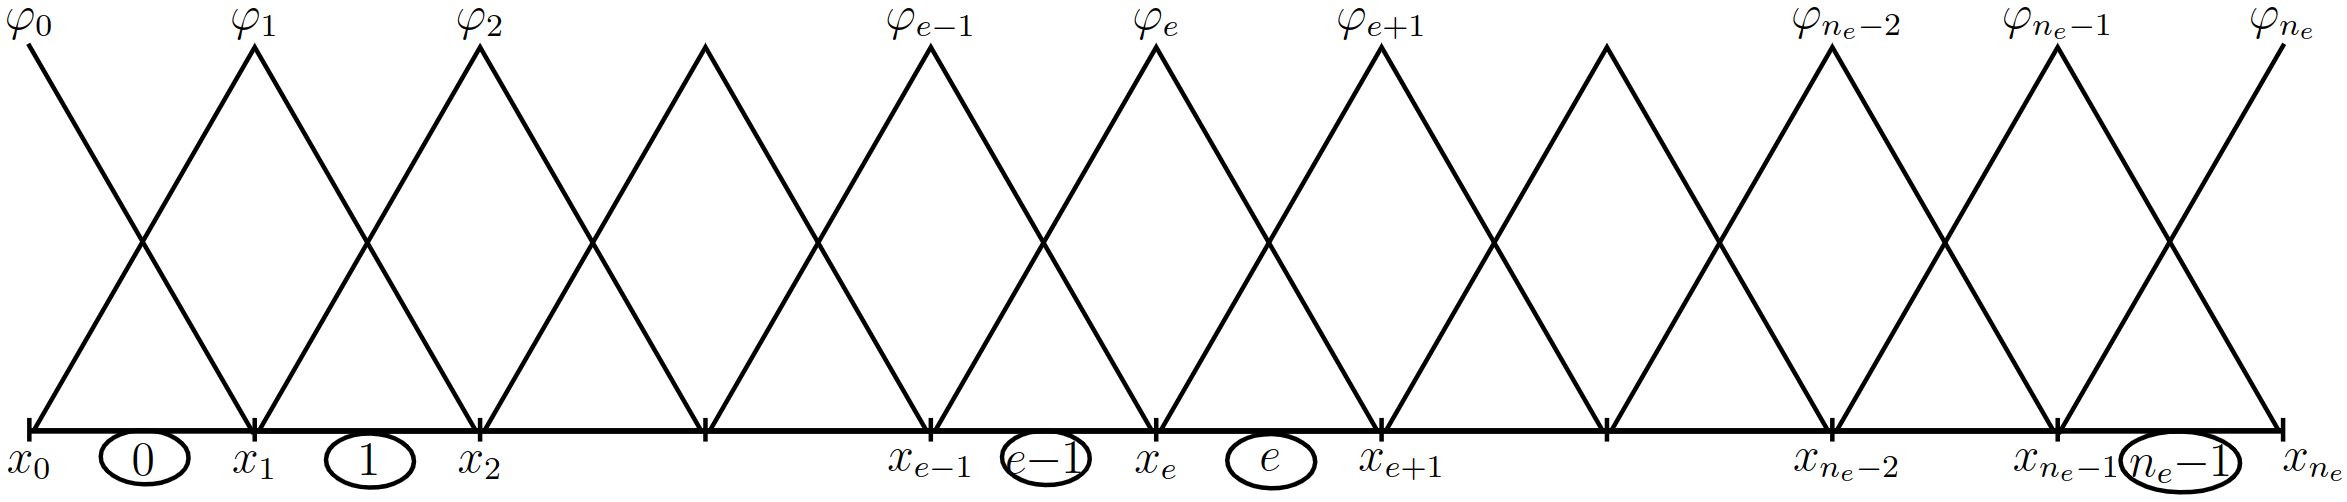

A relação entre a nomenclatura local e global das funções da base linear por partes é a seguinte:

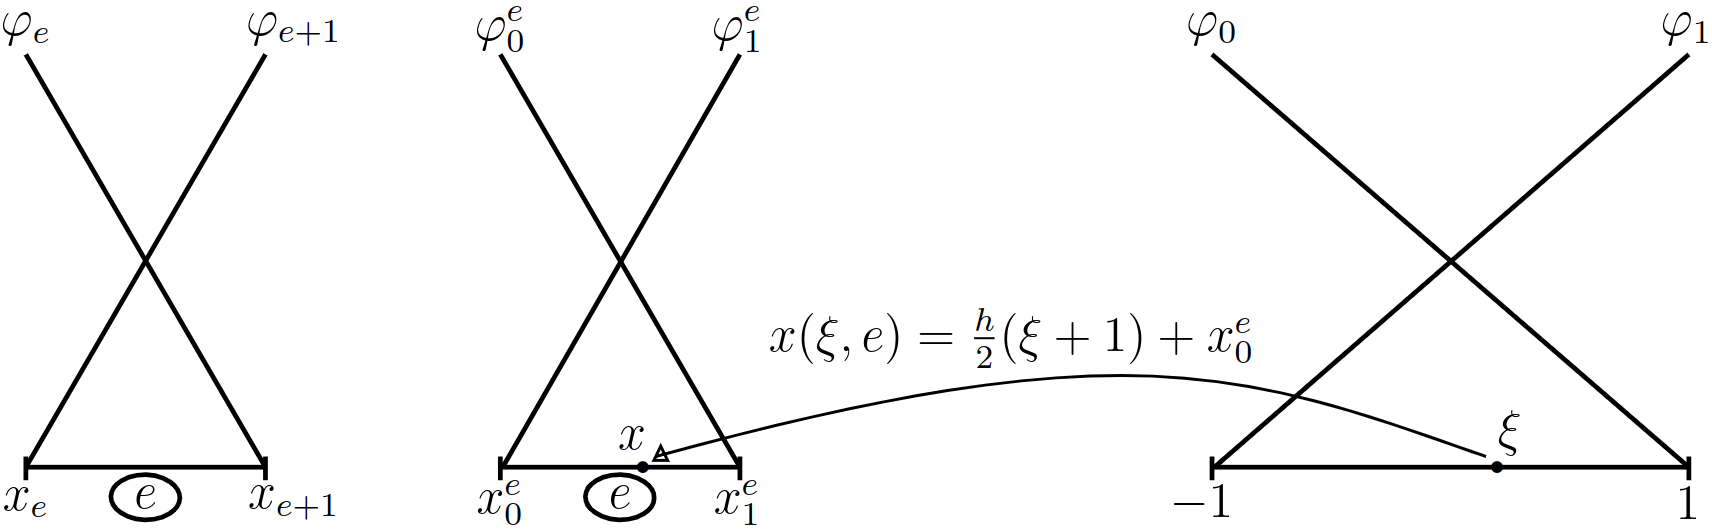

In [224]:
function PHI(P)
    return [(-1*P+1)/2, 
            (P+1)/2]
end

function dPHI(P)
    return [-1/2*(P.^0), 
            1/2*(P.^ 0)]
end

dPHI (generic function with 1 method)

In [225]:
function f_gauss(f, a, b)
    function g(ksi)
        dx = (b-a)/2
        x = (b-a)/2 * (ksi+1) + a
        return f(x)*dx
    end

    return g
end

function quadratura(f, a, b)
    n_gauss = 5
    P, W = legendre(n_gauss)

    g = f_gauss(f, a, b)

    return sum([W[i]*g(P[i]) for i in 1:n_gauss])
end

quadratura (generic function with 1 method)

# Monta K
A matriz local $K^e$ é definida como:
$$\begin{align*}\displaystyle
K_{a,b}^e =
  \frac{2\alpha}{h} \int_{-1}^{1}\frac{d\varphi_a}{d\xi}(\xi)\frac{d\varphi_b}{d\xi}(\xi)d\xi
+ \frac{\beta h}{2}  \int_{-1}^{1} \varphi_a(\xi)\varphi_b(\xi)d\xi,
\quad\text{com}\quad
a,\,b\in\{0,1\}.
\end{align*}$$

Uma vez construida a matriz local $K^e$, a montagem da matriz $K$ é a seguinte:

In [226]:
function K_local(X, e, alpha, beta)
    he = X[e+1] - X[e]

    f(x, a, b, phi) = phi(x)[a]*phi(x)[b]

    n_gauss = 2
    P, W = legendre(n_gauss)

    Ke = zeros((2, 2))
    for i in 1:2
        for j in 1:2
            g(x) = f(x, i, j, PHI)
            dg(x) = f(x, i, j, dPHI)

            dIntegral = 2*alpha/he*sum([W[i]*dg(P[i]) for i in 1:n_gauss])
            integral = he*beta/2*sum([W[i]*g(P[i]) for i in 1:n_gauss])

            Ke[i, j] = dIntegral + integral
        end
    end
    
    return Ke
end


function K_global(X, alpha, beta, m)
    K = zeros((m, m))

    e = 1
    K[1, 1] = K_local(X, e+1, alpha, beta)[2, 2]
    while e < m
        Ke = K_local(X, e, alpha, beta)
        for i in 1:2
            for j in 1:2
                K[(e-1)+i, (e-1)+j] += Ke[i, j]
            end
        end
        e += 1
    end
    K[m, m] += K_local(X, e+1, alpha, beta)[1, 1]

    return K
end

K_global (generic function with 1 method)

# Monta F
O vetor local $F^e$ é definido como:
$$\begin{align*}
F_a^e =
\frac{h}{2}\int_{-1}^1f\big(x(\xi,e)\big)\varphi_a(\xi)d\xi,
\quad\text{com}\quad
a\in\{0,1\}.
\end{align*}$$

Uma vez construido o vetor local $F^e$, a montagem vetorizada de $F$ é a seguinte:

In [227]:
function F_local(X, e, f, alpha, beta)
    he = X[e+1] - X[e]

    fe1(x) = f(x)*(X[e+1] - x)
    fe2(x) = f(x)*(x - X[e])

    Fe1 = quadratura(fe1, X[e], X[e+1])/he # integral X[i-1] ate X[i] de f(x)(x - X[i-1])
    Fe2 = quadratura(fe2, X[e], X[e+1])/he # integral X[i] ate X[i+1] de f(x)(X[i+1] - x)

    Fe = [Fe1, Fe2]

    return Fe
end

function F_global(X, f, alpha, beta, m)
    F = zeros(m)

    e = 1
    F[1] = F_local(X, e, f, alpha, beta)[2]
    e += 1

    while e < m+1
        Fe = F_local(X, e, f, alpha, beta)
        F[e-1] += Fe[1]
        F[e] += Fe[2]
        e += 1
    end
    F[m] += F_local(X, e, f, alpha, beta)[1]
    
    return F
end

F_global (generic function with 1 method)

In [228]:
function solve(exemplo, m)
    h = 1/(m+1)
    X = [(i-1)*h for i in 1:m+2]
  
    alpha, beta, f, u = exemplos(exemplo)
  
    K = K_global(X, alpha, beta, m)

    F = F_global(X, f, alpha, beta, m)
    
    C = K\F

    return X, C
  end

solve (generic function with 1 method)

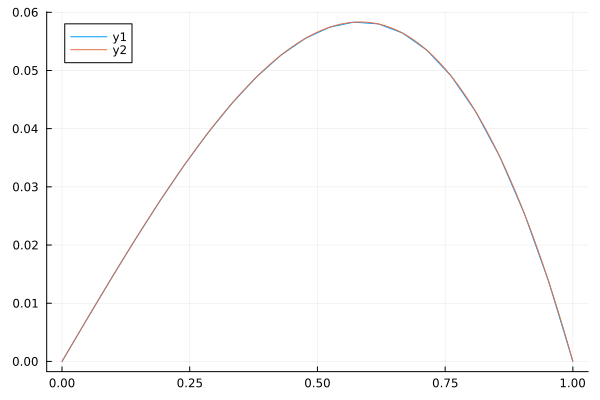

In [230]:
exemplo = 2; m = 20

X, C = solve(exemplo, m)

D = vcat(0, C, 0)

alpha, beta, f, u = exemplos(exemplo)
Xtest = 0:0.001:1

plot(X, D); plot!(Xtest, u)